# Pycuda
Il primo step è importare pycuda.autoinit, si occupera lui di preparare la GPU a ricevere delle istruzioni

In [1]:
import pycuda.autoinit
import pycuda.driver as cu
from pycuda import gpuarray
import numpy as np

## GPU arrays
Pycuda è pensato per poter operare sugli array di numpy. Per copiare gli array sulla gpu possiamo usare la funzione **gpuarray.to_gpu**, per ricopiare sull'host usiamo il metodo .get()

Nota che i gpu array sono dotati di aritmetica (come gli array numpy) e di numerosi metodi (come .sum() che torna la somma degli array) e funzioni matematiche che operano in maniera elementwise

Text(0, 0.5, 'time [s]')

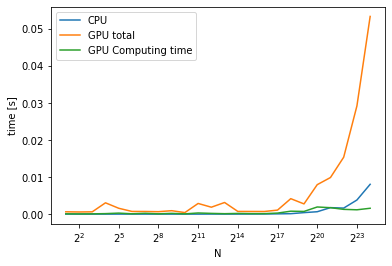

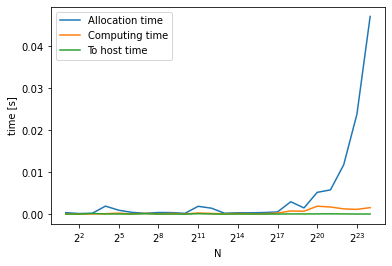

In [16]:
# Prodotto scalare tra due vettori
## OPINIONE PERSONALE: La somma di due vettori è facilmente parallelizzabile
# ma la somma dei suoi elementi è una operazione seriale quindi su questo la gpu perde
import time
import matplotlib.pyplot as plt
def gpu_scal_prod(h1_arr,h2_arr):
    start=time.time()
    dev1_arr=gpuarray.to_gpu(h1_arr)
    dev2_arr=gpuarray.to_gpu(h2_arr)
    allocating_time=time.time()-start
    start=time.time()
    dev_scal=gpuarray.dot(dev1_arr,dev2_arr)
    computing_time=time.time()-start
    start=time.time()
    host_scal=dev_scal.get()
    to_host=time.time()-start
    return host_scal,allocating_time, computing_time,to_host

def cpu_scal_prod(h1_arr,h2_arr):
    return np.dot(h1_arr,h2_arr)

N=np.logspace(1,24,num=24,dtype=np.int32,base=2)
host_time=[]
dev_time=[]
comp_time=[]
toh_time=[]
alloc_time=[]
for lenght in N:

    h1_arr=np.random.random(lenght).astype(np.float32)
    h2_arr=np.random.random(lenght).astype(np.float32)

    start=time.time()
    host_scal=cpu_scal_prod(h1_arr,h2_arr)
    host_time.append(time.time()-start)
    start=time.time()
    gpu_scal,allocating_time, computing_time,to_host=gpu_scal_prod(h1_arr,h2_arr)
    dev_time.append(time.time()-start)
    alloc_time.append(allocating_time)
    toh_time.append(to_host)
    comp_time.append(computing_time)



plt.plot(N,host_time,label='CPU')
plt.plot(N,dev_time,label='GPU total')
plt.plot(N,comp_time,label='GPU Computing time')
plt.legend()
plt.xscale("log",base=2)
plt.xlabel("N")
plt.ylabel("time [s]")

plt.figure()
plt.plot(N,alloc_time,label='Allocation time')
plt.plot(N,comp_time,label='Computing time')
plt.plot(N,toh_time,label='To host time')
plt.legend()
plt.xscale("log",base=2)
plt.xlabel("N")
plt.ylabel("time [s]")


Come si può facilmente vedere la totalità del tempo di esecuzione sulla GPU è dominato dal tempo di copia dell'array nella global memory della GPU

## C-Like memory management
Volendo possiamo allocare la memoria sulla gpu alla C maniera con malloc e memcpy_htod e ricopiare indietro don _dtoh

In questo modo creiamo un puntatore che possiamo passare a un kernel

## Scrittura di un C kernel
Possiamo scrivere un kernel in C importando il modulo SourceModule da pycuda.compiler

possiamo assegnare il kernel a una funzione python con .get_function e poi chiamarla passando come argomenti (oltre a quelli richiesti) block=(x,y,z) ovvero i thread da utilizzare per ogni blocco e grid=(gr,blocks) cioè quante griglie e quanti blocchi utilizzare

**NB, specifica sempre il tipo dei numpy array altrimenti fai casini enormi**

In [25]:
from pycuda.compiler import SourceModule
np_arr=np.array([1,2,3,4,5,6,7,8,9,10]).astype(np.int32)

#Copio array sulla GPU
cu_arr=cu.mem_alloc(np_arr.nbytes)
cu.memcpy_htod(cu_arr,np_arr)

#Definisco il kernel. Ovviamente si potrebbe leggere anche da file
mod = SourceModule("""
  __global__ void doublify(int *a)
    {
    int idx = blockDim.x*blockIdx.x+threadIdx.x;
    //printf("%d\\n",idx);
    a[idx] *= 2;
}
    """)
#Assegno funzione python
func=mod.get_function("doublify")

#Chiamo il kernel su 10 thread sull'asse x con 1 blocco (grid sono le coord dei blocchi)
func(cu_arr,block=(10,1,1),grid=(1,1))

# Ricopio indietro sull'host dopo aver creato un array vuoto
host_res=np.empty_like(np_arr)
cu.memcpy_dtoh(host_res,cu_arr)


# Libero il puntatore
cu_arr.free()
print(host_res)

##Volendo possiamo passare al kernel anche un gpu array
np_arr=np.arange(1,11).astype(np.int32)
gp_arr=gpuarray.to_gpu(np_arr)
func(gp_arr,block=(10,1,1),grid=(1,1))
gp_arr


[ 2  4  6  8 10 12 14 16 18 20]


array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20], dtype=int32)

### Elementwise
ElementWise è un modo per definire in modo veloce dei kernel molto semplice, basta definire il nome, gli argomenti e l'operazione da effettuare

Per usare questa funzione bisogna importare ElementwiseKernel da pycuda.elementwise

In [22]:
from pycuda.elementwise import ElementwiseKernel

myKer=ElementwiseKernel(arguments="float *a, float *b, float *c",
                        operation="c[i] = a[i] + b[i]",
                        name="myKer")

np1_arr=np.array([1,2,3,4,5,6,7,8,9,10]).astype(np.int32)
np2_arr=np.array([1,2,3,4,5,6,7,8,9,10]).astype(np.int32)
dev1_arr=gpuarray.to_gpu(np1_arr)
dev2_arr=gpuarray.to_gpu(np2_arr)
dev_res=gpuarray.empty_like(dev1_arr)
myKer(dev1_arr,dev2_arr,dev_res)
dev_res

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20], dtype=int32)

**NB**
E' importante notare che usare i gpuarray, gli ElementWise e i SourceModule porta a prestazioni molto differenti. gpu array è quello che performa peggio, SourceModule performa in base a quanti thread e blocchi settiamo noi a mano

## Advanced
Si possono creare anche delle strutture nel kernel e wrappare una classe python alla struttura kernel, essenzialmente nell'init della classe bisogna copiare il puntatore nella gpu ma non approfondiamo più di tanto